In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Visualization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import h5py
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import roc_curve,RocCurveDisplay,ConfusionMatrixDisplay,confusion_matrix,roc_auc_score,accuracy_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv1D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# bad => ['/device:CPU:0']
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [3]:
import h5py
with h5py.File('data.h5', 'r') as hf:
    X = hf['EEG_values'][:]             #Samples tensor
    y = hf['target_values'][:]          #Targets matrix


In [4]:
X = np.delete(X,[0,1,2,3,4],1)

In [5]:
No_Activity_Events = np.where(y==0)[0]
len(No_Activity_Events)

1000

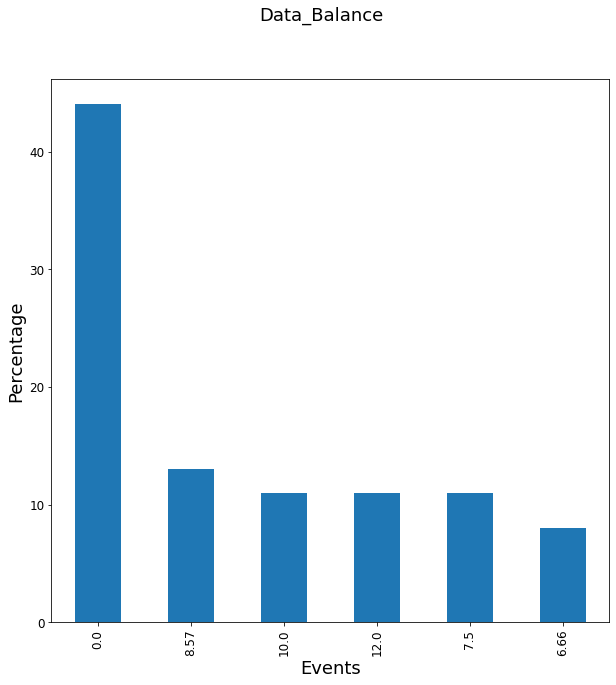

In [6]:
Events = pd.Series(y).to_frame().rename(columns={0: "Events"})['Events'].astype(str)
type_counts = Events.value_counts()
Coutns = type_counts.sum(axis = 0)
for i in range(len(type_counts)):
    type_counts.iloc[i] = int((type_counts.iloc[i]/Coutns)*100)
ax =type_counts.plot(kind='bar' , figsize =(10,10)  , fontsize = 12);
plt.suptitle('Data_Balance', fontsize=18);
plt.ylabel('Percentage', fontsize=18);
plt.xlabel('Events', fontsize=18);

In [7]:
#drop 0 till 250 samples
list_=[]
Start = int(No_Activity_Events[0])
for i in range(10):
    list_ = list_ + [*range(Start+100*i,Start+100*(i+1)-30)]
y = np.delete(y, list_, 0)
X = np.delete(X, list_, 0)
No_Activity_Events = np.where(y==0)[0]
len(No_Activity_Events)

300

In [8]:
y.shape

(1550,)

In [9]:
#Leave one out spliting
from keras.utils import np_utils

X_valid = ["X_valid" + str(i) for i in range (10)]
X_train = ["X_train" + str(i) for i in range (10)]
y_valid = ["y_valid" + str(i) for i in range (10)]
y_train = ["y_train" + str(i) for i in range (10)]

Mapping = { 0.00   : 0,
           12.00   : 1,
           10.00   : 2,
           8.57    : 3,
           7.50    : 4,
           6.66    : 5    }

for i in range(0 , y.shape[0]):
    Key  = float(str(y[i]))
    y[i] = Mapping[Key]
    
y = y.astype(int)

y = np_utils.to_categorical(y, 6)

#Firstly, spliting Subjects for frequencies
val = 0 
for i in range(0,int(No_Activity_Events[0]),125):
    
    X_valid[val] = X[i:i+125]
    X_train[val] = np.delete(X, [*range(i,i+125)] + [*range(int(No_Activity_Events[0]),int(No_Activity_Events[-1]))], 0)
    y_valid[val] = y[i:i+125]
    y_train[val] = np.delete(y, [*range(i,i+125)] + [*range(int(No_Activity_Events[0]),int(No_Activity_Events[-1]))], 0)
    val += 1

#Secondly, spliting Subjects for No Activity
val = 0
for j in range(No_Activity_Events[0],int(No_Activity_Events[-1]),30):
    
    X_valid[val] = np.concatenate((X_valid[val], X[j:j+30]), axis=0)
    X_train[val] = np.concatenate((X_train[val], np.delete(X, [*range(j,j+30)] + [*range(0,int(No_Activity_Events[0]))], 0)), axis=0)
    y_valid[val] = np.concatenate((y_valid[val], y[j:j+30]), axis=0)
    y_train[val] = np.concatenate((y_train[val], np.delete(y, [*range(j,j+30)] + [*range(0,int(No_Activity_Events[0]))], 0)), axis=0)
    val += 1

In [23]:
def Tensors(i = 0):
    
    Y_train_tensor = y_train[i]
    X_train_tensor = X_train[i]
    X_valid_Tensor = X_valid[i]
    Y_valid_Tensor = y_valid[i]
    
    return (X_train_tensor,Y_train_tensor,X_valid_Tensor,Y_valid_Tensor)

X_train_tensor , Y_train_tensor , X_valid_Tensor , Y_valid_Tensor =  Tensors(8)


In [11]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [12]:
EPOCH = 300
BATCH_SIZE = 256

In [97]:
model = keras.models.Sequential([
            keras.layers.Input(shape=X.shape[-2:]),
            keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=False)),
#             keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
            keras.layers.Dense(128, activation='selu'),
#             keras.layers.Dropout(0.1),
            keras.layers.Dense(6),
        ])

In [98]:
model.compile(optimizer='adam', loss='mae')

In [99]:
Y_train_tensor.shape

(1396, 6)

In [ ]:
history = model.fit(X_train_tensor, Y_train_tensor, validation_data =(X_valid_Tensor, Y_valid_Tensor) ,  epochs = 1000, batch_size = BATCH_SIZE ,
    verbose=1)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
del model
model = Architecture(input_shape = (640,9) ,  classes = 6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/1000
6/6 [==============================] - 1s 52ms/step - loss: 0.1689 - val_loss: 0.1707
Epoch 2/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1702 - val_loss: 0.1704
Epoch 3/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1703 - val_loss: 0.1702
Epoch 4/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1703 - val_loss: 0.1692
Epoch 5/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1703 - val_loss: 0.1701
Epoch 6/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1698 - val_loss: 0.1697
Epoch 7/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1700 - val_loss: 0.1687
Epoch 8/1000
6/6 [==============================] - 0s 49ms/step - loss: 0.1700 - val_loss: 0.1686
Epoch 9/1000
6/6 [==============================] - 0s 49ms/step - loss: 0.1692 - val_loss: 0.1696
Epoch 10/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1695 - val_loss: 0.1710
Epoch 11/

6/6 [==============================] - 0s 46ms/step - loss: 0.1682 - val_loss: 0.1683
Epoch 84/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1685 - val_loss: 0.1676
Epoch 85/1000
6/6 [==============================] - 0s 52ms/step - loss: 0.1680 - val_loss: 0.1675
Epoch 86/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1676 - val_loss: 0.1681
Epoch 87/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1679 - val_loss: 0.1686
Epoch 88/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1683 - val_loss: 0.1683
Epoch 89/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1681 - val_loss: 0.1683
Epoch 90/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1681 - val_loss: 0.1688
Epoch 91/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1683 - val_loss: 0.1677
Epoch 92/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1678 - val_loss: 0.1677
Epoch 93/1000


6/6 [==============================] - 0s 48ms/step - loss: 0.1680 - val_loss: 0.1679
Epoch 165/1000
6/6 [==============================] - 0s 48ms/step - loss: 0.1679 - val_loss: 0.1680
Epoch 166/1000
6/6 [==============================] - 0s 49ms/step - loss: 0.1681 - val_loss: 0.1683
Epoch 167/1000
6/6 [==============================] - 0s 50ms/step - loss: 0.1679 - val_loss: 0.1680
Epoch 168/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1678 - val_loss: 0.1676
Epoch 169/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1674 - val_loss: 0.1676
Epoch 170/1000
6/6 [==============================] - 0s 49ms/step - loss: 0.1673 - val_loss: 0.1673
Epoch 171/1000
6/6 [==============================] - 0s 50ms/step - loss: 0.1674 - val_loss: 0.1673
Epoch 172/1000
6/6 [==============================] - 0s 47ms/step - loss: 0.1675 - val_loss: 0.1678
Epoch 173/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1676 - val_loss: 0.1678
Epoch

6/6 [==============================] - 0s 46ms/step - loss: 0.1674 - val_loss: 0.1677
Epoch 246/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1675 - val_loss: 0.1675
Epoch 247/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1676 - val_loss: 0.1679
Epoch 248/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1678 - val_loss: 0.1683
Epoch 249/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1679 - val_loss: 0.1683
Epoch 250/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1680 - val_loss: 0.1682
Epoch 251/1000
6/6 [==============================] - 0s 47ms/step - loss: 0.1681 - val_loss: 0.1679
Epoch 252/1000
6/6 [==============================] - 0s 47ms/step - loss: 0.1678 - val_loss: 0.1675
Epoch 253/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1678 - val_loss: 0.1678
Epoch 254/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1676 - val_loss: 0.1677
Epoch

6/6 [==============================] - 0s 46ms/step - loss: 0.1675 - val_loss: 0.1672
Epoch 327/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1675 - val_loss: 0.1674
Epoch 328/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1676 - val_loss: 0.1675
Epoch 329/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1676 - val_loss: 0.1677
Epoch 330/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1674 - val_loss: 0.1674
Epoch 331/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1673 - val_loss: 0.1672
Epoch 332/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1674 - val_loss: 0.1679
Epoch 333/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1677 - val_loss: 0.1675
Epoch 334/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1677 - val_loss: 0.1674
Epoch 335/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1677 - val_loss: 0.1678
Epoch

6/6 [==============================] - 0s 48ms/step - loss: 0.1673 - val_loss: 0.1672
Epoch 408/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1673 - val_loss: 0.1671
Epoch 409/1000
6/6 [==============================] - 0s 50ms/step - loss: 0.1674 - val_loss: 0.1678
Epoch 410/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1674 - val_loss: 0.1672
Epoch 411/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1675 - val_loss: 0.1677
Epoch 412/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1677 - val_loss: 0.1674
Epoch 413/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1675 - val_loss: 0.1675
Epoch 414/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.1675 - val_loss: 0.1677
Epoch 415/1000
6/6 [==============================] - 0s 49ms/step - loss: 0.1674 - val_loss: 0.1676
Epoch 416/1000
6/6 [==============================] - 0s 47ms/step - loss: 0.1675 - val_loss: 0.1675
Epoch

In [116]:
X_valid_Tensor[1].shape[-2:]

(9, 640)

In [110]:
shape = [tf.shape(X_valid_Tensor[1])[k] for k in range(2)]

In [114]:
tf.reshape(X_valid_Tensor[1], [shape[0], shape[1]]).shape

TensorShape([9, 640])

In [115]:
y_h = model.predict(X_valid_Tensor[1])

ValueError: in user code:

    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "E:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "E:\Anaconda\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_27" is incompatible with the layer: expected shape=(None, 9, 640), found shape=(None, 640)


In [65]:
layer = keras.layers.LSTM()
tf.keras.layers.Bidirectional(
    layer, merge_mode="concat", weights=None, backward_layer=None)

TypeError: __init__() missing 1 required positional argument: 'units'

In [87]:
model = Sequential()
model.add(LSTM(1024, return_sequences = True, input_shape=(9,640)))
model.add(Dense(128, activation='selu'))
model.add(Dense(6, activation='selu'))

In [88]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [89]:
history = model.fit(X_train_tensor, Y_train_tensor, validation_data =(X_valid_Tensor, Y_valid_Tensor) ,  epochs = 10, batch_size = BATCH_SIZE ,
    verbose=1)

Epoch 1/10


ValueError: in user code:

    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "E:\Anaconda\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "E:\Anaconda\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "E:\Anaconda\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "E:\Anaconda\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "E:\Anaconda\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 6) and (None, 9, 6) are incompatible
